In [2]:
import os
import sys
import argparse
from os.path import dirname, realpath


In [3]:
sys.path.append("./src/")
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [4]:
%run load_PheOnly.py

In [5]:
wts01 = np.where(gold1 == 1, 1/(np.mean(gold1)* np.mean(.064)* (1-mp1) **1), 1/ mp1**1)
wts02 = np.where(gold2 == 1, 1/(np.mean(gold2)* np.mean(.064)* (1-mp2) **1), 2/ mp2**1)
wts03 = np.where(gold3 == 1, 1/(np.mean(gold3)*np.mean(.064) *(1-mp3) **1), 3/ mp3**1)
wts04 = np.where(gold4 == 1, 1/(np.mean(gold4)*np.mean(.064)* (1-mp4) **1), 4/ mp4**1)

In [6]:
np.mean(gold0)

0.018841341999474022

In [7]:
wts01 = np.where(gold1 == 1, 4/(np.mean(gold1)* (1-mp1) ), 1/ mp1)
wts02 = np.where(gold2 == 1, 4/(np.mean(gold2)* (1-mp2) ), 2/ mp2)
wts03 = np.where(gold3 == 1, 4/(np.mean(gold3)* (1-mp3) ), 3/ mp3)
wts04 = np.where(gold4 == 1, 4/(np.mean(gold4)* (1-mp4) ), 4/ mp4)


In [8]:
wts1234 = np.concatenate((wts01,wts02, wts03, wts04))
y1234 = np.concatenate((gold1,gold2, gold3, gold4))
lo1234 = logit( np.concatenate((mp1,mp2, mp3, mp4)) )
tlo1234 = logit( np.concatenate((tp1,tp2, tp3, tp4)) )
ti = np.concatenate((np.ones(len(mp1)), 2*np.ones(len(mp2)), 3*np.ones(len(mp3)), 4*np.ones(len(mp4))))
tti = np.concatenate((np.ones(len(tp1)), 2*np.ones(len(tp2)), 3*np.ones(len(tp3)), 4*np.ones(len(tp4))))

In [9]:
def weighted_temp2_scaling (logits, y, wts):
    def temperature_obj(t):
        temp_logits =   (logits + t[1]) /  t [0]  
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize (temperature_obj,x0 = [.1,.1])
    return res.x

def temp_pred2 (alpha,  test_logit):    
    logi =  (test_logit + alpha[1])/ alpha[0]     
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [10]:
alpha_0_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)


In [11]:
pc = temp_pred2(alpha_0_1234, lo1234 )

(array([24436.,  8417.,  5152.,  3732.,  2896.,  2394.,  2057.,  1918.,
         1607.,   625.]),
 array([0.00319168, 0.0985322 , 0.19387273, 0.28921325, 0.38455377,
        0.4798943 , 0.57523482, 0.67057535, 0.76591587, 0.8612564 ,
        0.95659692]),
 <BarContainer object of 10 artists>)

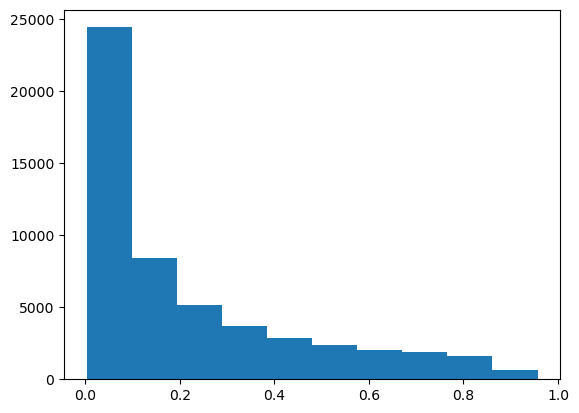

In [12]:
plt.hist(pc)

In [13]:
wp1 = ( pc [ti==1])
wp2 = ( pc [ti==2]) 
wp3 = ( pc [ti==3]) 
wp4 =  (pc [ti==4])
np1 =  ((1-pc) [ti==1])
np2 =  ((1-pc) [ti==2])
np3 =  ((1-pc) [ti==3])
np4 =  ((1-pc) [ti==4])

In [14]:
wts1 = np.where(gold1 == 1, 1/( np1 *np.mean(gold1)), 1/wp1)
wts2 = np.where(gold2 == 1, 1/( np2 *np.mean(gold2)), 1/wp2)
wts3 = np.where(gold3 == 1, 1/( np3 *np.mean(gold3)), 1/wp3 )
wts4 = np.where(gold4 == 1, 1/( np4 *np.mean(gold4)), 1/wp4 )

In [15]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1* t[5]  +  t[1])  
        logi_2 = (l2 * t[6]  +  t[2])  
        logi_3 = (l3 * t[7] +  t[3])  
        logi_4 = (l4 * t[8] +  t[4])  
        
        p1  = expit (t[0] * logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] * logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1, .1  ] )    
    return  r

In [16]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [17]:
tt['message']

'Optimization terminated successfully.'

In [18]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit * j2    + j1    )  
    proba = expit (  logi * tt.x[0]  )  
    return proba

In [19]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

y1, p1 = calibration_curve(M_test1['golds'], cal_1 , n_bins = 250)
y2, p2 = calibration_curve(M_test2['golds'], cal_2 , n_bins = 250)
y3, p3 =calibration_curve(M_test3['golds'], cal_3 , n_bins = 250)
y4, p4 = calibration_curve(M_test4['golds'], cal_4 , n_bins = 250)

In [20]:
p4_ = p4 [y4>0]
y4_ = y4 [y4>0]
p3_ = p3 [y3>0]
y3_ = y3 [y3>0]
p2_ = p2 [y2>0]
y2_ = y2 [y2>0]
p1_ = p1 [y1>0]
y1_ = y1 [y1>0]

<module 'matplotlib.pyplot' from 'D:\\Programs\\Anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

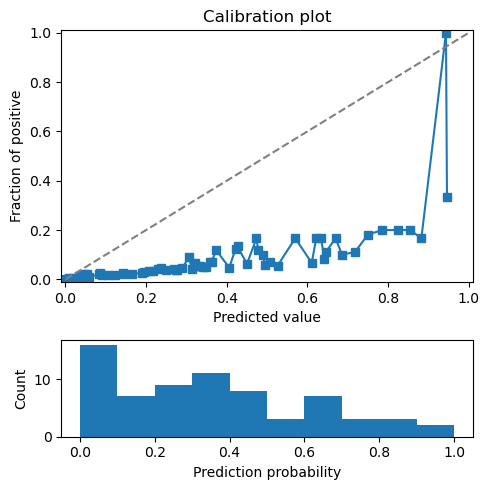

In [20]:
plotter(p4_, y4_)

<module 'matplotlib.pyplot' from 'D:\\Programs\\Anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

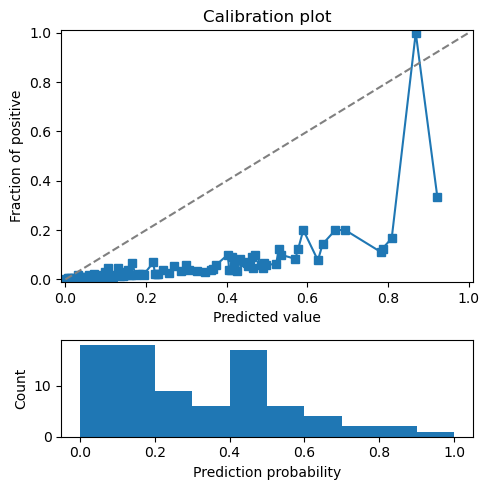

In [21]:
plotter(p3_, y3_)

<module 'matplotlib.pyplot' from 'D:\\Programs\\Anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

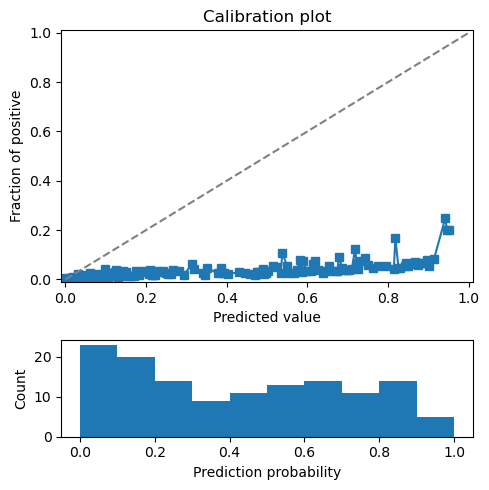

In [22]:
plotter(p2_, y2_)

<module 'matplotlib.pyplot' from 'D:\\Programs\\Anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

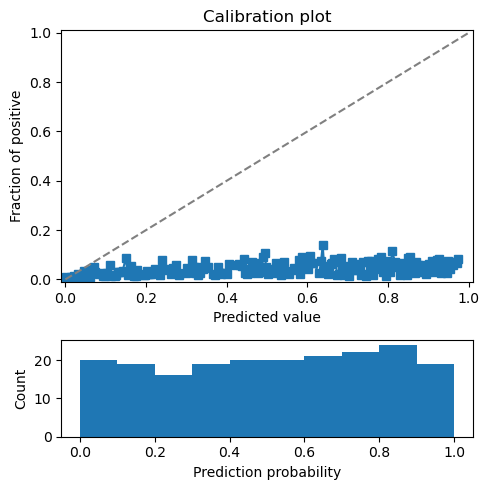

In [23]:
plotter(p1_, y1_)

In [24]:
import sklearn
from sklearn.metrics import confusion_matrix

In [25]:
[sklearn.metrics.roc_auc_score(tgold4,  tp4 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold3,  tp3 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold2,  tp2 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold1,  tp1 , average = 'samples')]


[0.7072423069302404,
 0.6854529873329583,
 0.6455460267776995,
 0.6480031999535442]

In [26]:
( confusion_matrix (tgold1,  cal_1>.5) )

array([[8917, 6602],
       [ 185,  321]], dtype=int64)

In [27]:
( confusion_matrix (tgold2,  cal_2>.5) )

array([[11368,  2487],
       [  126,    73]], dtype=int64)

In [28]:
( confusion_matrix (tgold3,  cal_3>.5) )

array([[11579,   868],
       [  114,    18]], dtype=int64)

In [29]:
( confusion_matrix (tgold4,  cal_4>.5) )

array([[9886,  826],
       [  78,   20]], dtype=int64)